# Dealing with Bias and Fairness in Data Science Systems
## KDD 2020 Hands-on Tutorial
### Pedro Saleiro, Kit Rodolfa, Rayid Ghani

# <font color=red>Exploring Bias Reduction Strategies</font>

### 1. Install dependencies, import packages and data
This is needed every time you open this notebook in **colab** to install dependencies

In [41]:
!pip install aequitas
import yaml
import os
import pandas as pd
import numpy as np
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
#import aequitas.plot as ap
import matplotlib.pyplot as plt
sns.set() 
DPI = 200
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'


## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. 

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Preicision at top 1000**.

### <font color=red>We audited the "best" model at precision at top 1000 and found that it has disparities for True Positive Rate for all attributes that we care about (poverty_level of the school, sex, and school_location_type)</font>


## What do we want to do now?

1. Could we have picked a different model that was similar enough in "precision at top 1000" but less biased?


## Load predictions, labels, and attributes for all models that were built to audit

In [42]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')


In [43]:
evals_df.head(10)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31
2,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31
3,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31
4,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31
5,0.547,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",856a91cee8d3e81d35b0c7578d8459cb,dc9f61602f5c90b70aa8e6040eaf2972,1000,test,2012-12-01,2013-01-31
6,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",9d582bc500e1d99e0949ec9d35ae8eb3,d3de1db6eed5cfab17d64d6a13e20c8d,1000,test,2012-12-01,2013-01-31
7,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",bcc12af1a0ae151aabd5238e3a4fb242,eb671681600d5304fce6873004c61c50,1000,test,2012-12-01,2013-01-31
8,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",7fa15e633491add493d45e9dc7440315,5bd60c3f912e6d62b9acf7b3a56ae803,1000,test,2012-12-01,2013-01-31
9,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",da8d97ec5529f435974e238b1b29cf7f,4cd560dcb70bfe5bfef3ad1628eaba8a,1000,test,2012-12-01,2013-01-31


### Spot-check one model to see what type it is

In [44]:
evals_df['hyperparameters'][0]

'{"n_jobs": -1, "criterion": "gini", "max_depth": 30, "max_features": "sqrt", "n_estimators": 87, "random_state": 213500298, "min_samples_leaf": 44, "min_samples_split": 3}'

## Load pre-computed Aequitas audit results 

In [45]:
aequitas_df = pd.read_csv(DATAPATH + 'split2_aequitas.csv.gz', compression='gzip')


In [46]:
aequitas_df.shape

(2400, 16)

In [47]:
aequitas_df.head(10)

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
0,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban_rural,0.139156,1.000000,suburban_rural,626,333,2393,0.367814,6506,test,2012-12-01,2013-01-31
1,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,0.306665,suburban_rural,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31
2,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,female,0.102390,3.370670,male,951,527,5147,0.341019,15093,test,2012-12-01,2013-01-31
3,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,lower,0.137859,1.000000,lower,753,394,2858,0.370976,7704,test,2012-12-01,2013-01-31
4,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,highest,0.050771,0.368285,lower,247,158,3112,0.312043,9973,test,2012-12-01,2013-01-31
5,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,male,0.030377,1.000000,male,49,25,823,0.318498,2584,test,2012-12-01,2013-01-31
6,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,lower,0.149405,1.000000,lower,805,427,2858,0.370976,7704,test,2012-12-01,2013-01-31
7,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,highest,0.039846,0.266696,lower,195,124,3112,0.312043,9973,test,2012-12-01,2013-01-31
8,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,female,0.101613,2.986684,male,944,523,5147,0.341019,15093,test,2012-12-01,2013-01-31
9,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,male,0.034022,1.000000,male,56,28,823,0.318498,2584,test,2012-12-01,2013-01-31


2.715288431513638

## Let's see if we could have picked a better model for fairness in Poverty Level

In [92]:
def create_scatter_disparity_performance(evals_df, aequitas_df, attr_col, group_name, performance_col='model_precision', bias_metric='tpr', flip_disparity=True):
    disparity_df = aequitas_df.loc[(aequitas_df['attribute_name']==attr_col) & (aequitas_df['attribute_value']==group_name)].copy()
    disparity_metric = bias_metric + '_disparity'
    if flip_disparity:
        disparity_df[disparity_metric]= poverty_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
    scatter = pd.merge(evals_df, disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)
    ax = sns.scatterplot(
        x='model_precision', y=disparity_metric,#, hue='Model Type',# hue='model_type',
        data=scatter1,
        alpha=0.5, s=20,
    )
    #ax.set_title('Poverty Level Max TPR Disparity vs. Model Precision', y=1.)
    plt.gcf().set_size_inches((5, 4))
    plt.gcf().set_dpi(DPI)
    plt.show() 

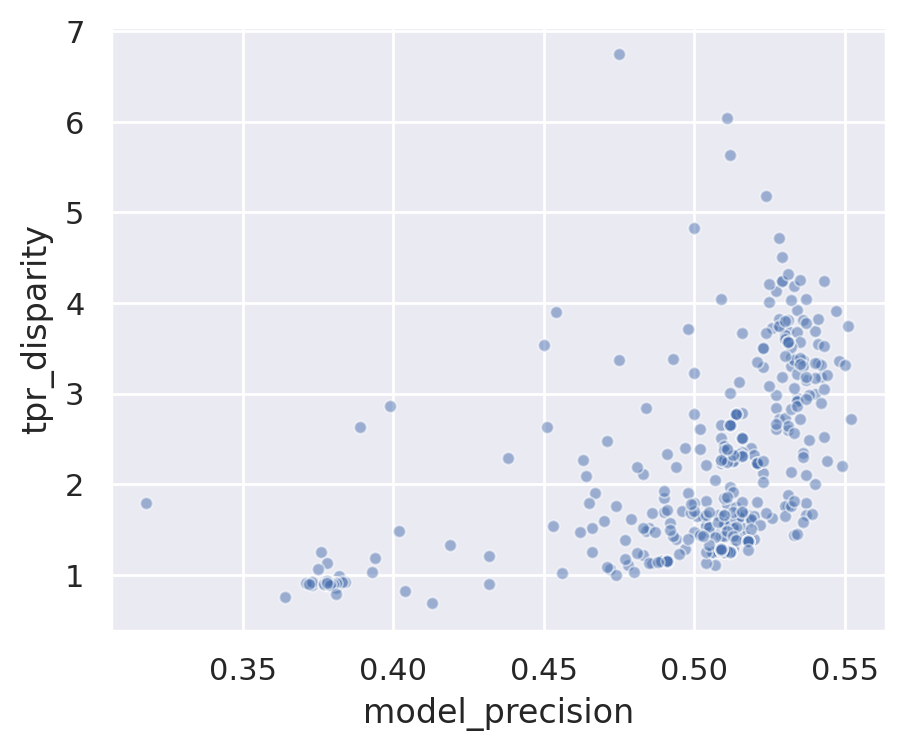

In [93]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'poverty_level', 'highest' )

In [82]:
poverty_disparity_df = aequitas_df[aequitas_df['attribute_value']=='highest'].copy()
metric = 'tpr'
disparity_metric = metric + '_disparity'
poverty_disparity_df[disparity_metric]= poverty_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)

scatter1.sort_values('model_precision', ascending=False)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid_x,target_pp,matrix_type_x,matrix_start_date_x,matrix_end_date_x,predictions_uuid_y,...,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type_y,matrix_start_date_y,matrix_end_date_y
4,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31,c598fbe93f4c218ac7d325fb478598f1,...,-2.715292,lower,247,158,3112,0.312043,9973,test,2012-12-01,2013-01-31
7,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31,2d8e4d82f4e67e1de1de8650a7838fc2,...,-3.749588,lower,195,124,3112,0.312043,9973,test,2012-12-01,2013-01-31
17,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31,5e78e49f70fac0193eaadb8513428f23,...,-3.314659,lower,217,136,3112,0.312043,9973,test,2012-12-01,2013-01-31
21,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31,f04edad1446642411085e84271898506,...,-2.195695,lower,282,182,3112,0.312043,9973,test,2012-12-01,2013-01-31
26,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31,09092f371176a13cddca59bac20da4fd,...,-3.364131,lower,209,134,3112,0.312043,9973,test,2012-12-01,2013-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,0.373,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.000046230697658765085, ""beta_1"": 0...",051ec91964c80602419a53ee1a4b1610,7160d99b4710ff05c078d7945e0478c1,1000,test,2012-12-01,2013-01-31,7160d99b4710ff05c078d7945e0478c1,...,0.132853,lower,588,206,3112,0.312043,9973,test,2012-12-01,2013-01-31
2376,0.372,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.000022779312051721987, ""beta_1"": 0...",e79173c1595bc2ba28edee0c01467fa9,b16ad6b2a7eba2e6ba30c14981ebaf3b,1000,test,2012-12-01,2013-01-31,b16ad6b2a7eba2e6ba30c14981ebaf3b,...,0.115176,lower,573,204,3112,0.312043,9973,test,2012-12-01,2013-01-31
2383,0.371,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.0000629250653559928, ""beta_1"": 0.9...",5423f461c575db9934e52b49c2aabf0f,ca1c9b8e742db3761a660cac81a19102,1000,test,2012-12-01,2013-01-31,ca1c9b8e742db3761a660cac81a19102,...,0.097709,lower,571,202,3112,0.312043,9973,test,2012-12-01,2013-01-31
2391,0.364,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 14, ""num_leaves"": ...",853e04831b0a855f22f4bd46b995223c,3e9271171981a27f976a9ef8c739cad0,1000,test,2012-12-01,2013-01-31,3e9271171981a27f976a9ef8c739cad0,...,0.325180,lower,643,215,3112,0.312043,9973,test,2012-12-01,2013-01-31


In [58]:
poverty_tpr_disparity_df.head()

4     0.368285
7     0.266696
17    0.301690
21    0.455437
26    0.297254
Name: tpr_disparity, dtype: float64

In [83]:
scatter1 = df = pd.merge(evals_df, poverty_disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)

In [63]:
len(scatter1)

400

### Plot Disparity vs Precision at 1000 to explore the tradeoff

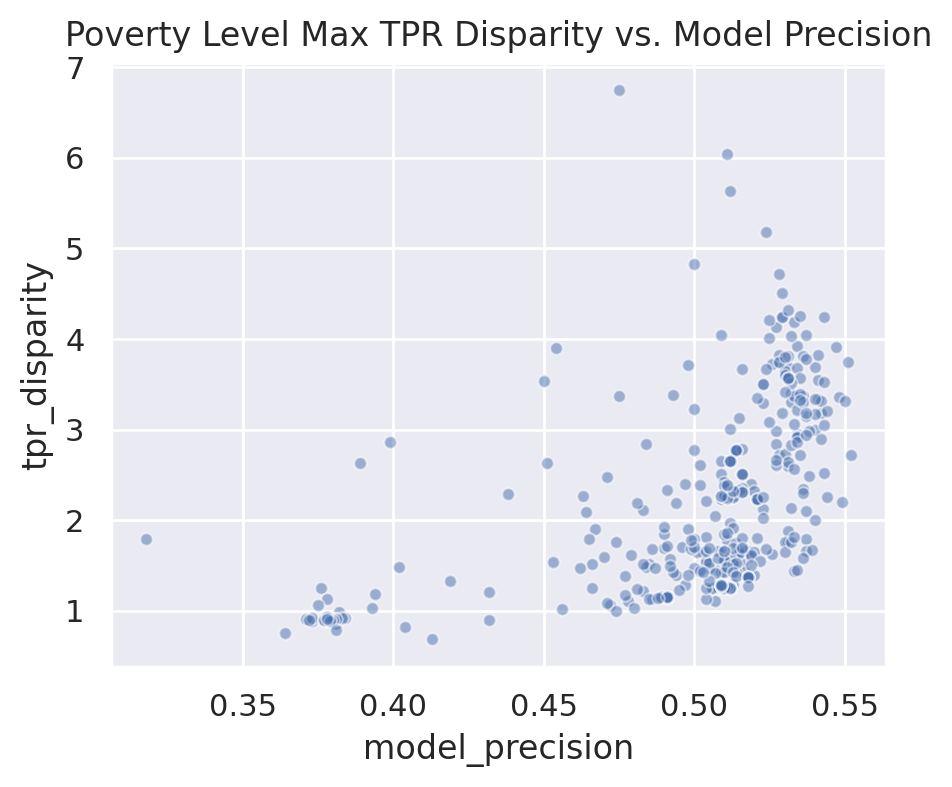

In [84]:
ax = sns.scatterplot(
    x='model_precision', y='tpr_disparity',#, hue='Model Type',# hue='model_type',
    data=scatter1,
    alpha=0.5, s=20,
)
ax.set_title('Poverty Level Max TPR Disparity vs. Model Precision', y=1.)

plt.gcf().set_size_inches((5, 4))
plt.gcf().set_dpi(DPI)
#plt.gcf().savefig(f'{NEW_IMGS_DIR}/fairness_vs_performance_density_per_model.png', dpi=DPI)
plt.show() 

## Let's now do the same for the sex of the teacher that submitted the project

In [20]:
teacher_sex_tpr_disparity_df = aequitas_df[aequitas_df['attribute_name']=='teacher_sex'].groupby(['model_uuid','attribute_name']).tpr_disparity.agg('max').to_frame().reset_index()

In [21]:
scatter3 = pd.merge(evals_df, teacher_sex_tpr_disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)


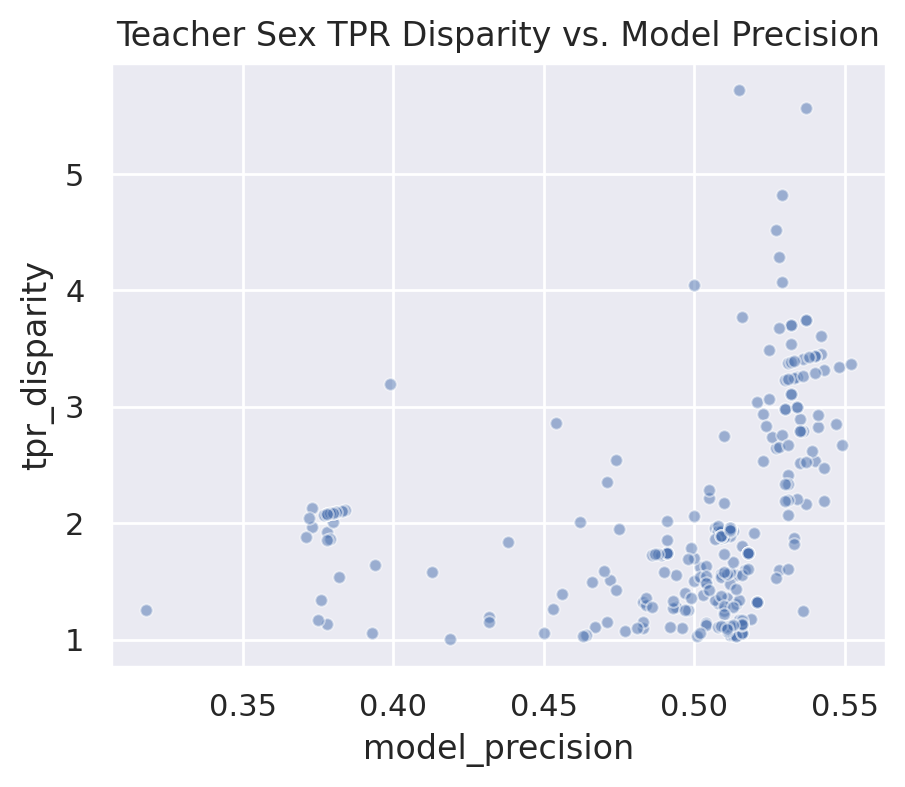

In [22]:
ax = sns.scatterplot(
    x='model_precision', y='tpr_disparity',
    
    data=scatter3,
    alpha=0.5, s=20,
)
ax.set_title('Teacher Sex TPR Disparity vs. Model Precision', y=1.)

plt.gcf().set_size_inches((5, 4))
plt.gcf().set_dpi(DPI)
#plt.gcf().savefig(f'{NEW_IMGS_DIR}/fairness_vs_performance_density_per_model.png', dpi=DPI)
plt.show() 

In [23]:
scatter3.loc[(scatter3['model_precision'] > 0.53) & (scatter3['tpr_disparity'] < 1.3)].sort_values('model_precision', ascending=False)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date,attribute_name,tpr_disparity
92.0,0.536,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.00016633092978140688, ""beta_1"": 0....",44e6d311dec67b33677d42836f38ad32,854de2c0c632395d508c7fd9ec3500ce,1000,test,2012-12-01,2013-01-31,teacher_sex,1.245115


## Now look at Metro_type

In [24]:
metro_type_tpr_disparity_df = aequitas_df[aequitas_df['attribute_name']=='metro_type'].groupby(['model_uuid','attribute_name']).tpr_disparity.agg('max').to_frame().reset_index()

In [25]:
scatter4 = pd.merge(evals_df, metro_type_tpr_disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)


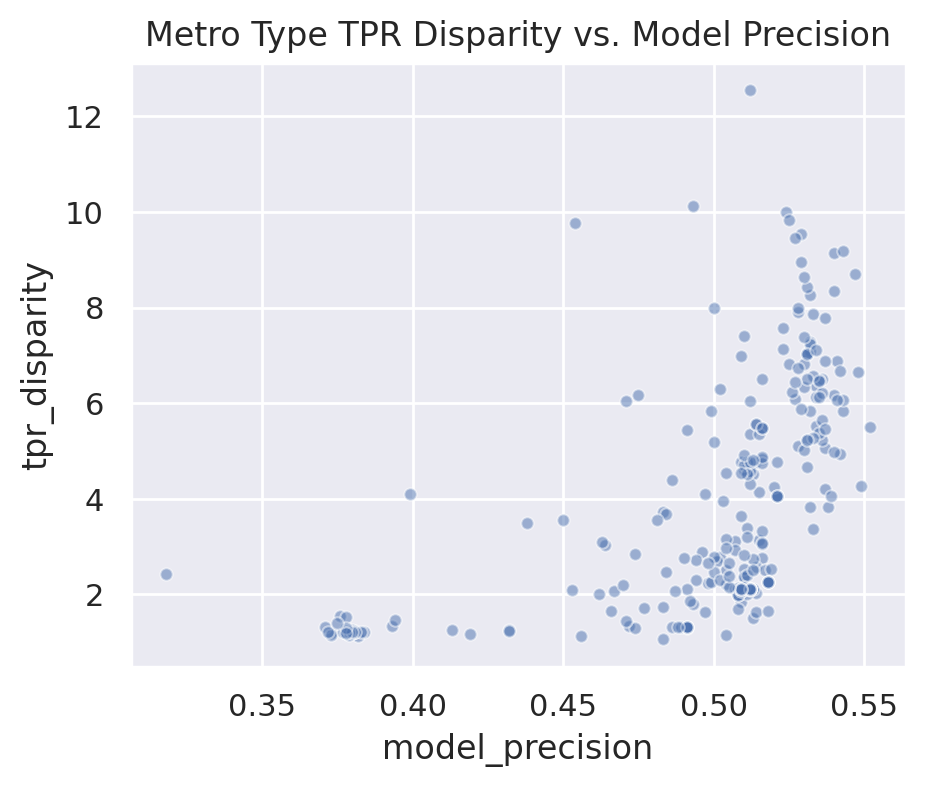

In [26]:
ax = sns.scatterplot(
    x='model_precision', y='tpr_disparity',
    
    data=scatter4,
    alpha=0.5, s=20,
)
ax.set_title('Metro Type TPR Disparity vs. Model Precision', y=1.)

plt.gcf().set_size_inches((5, 4))
plt.gcf().set_dpi(DPI)
#plt.gcf().savefig(f'{NEW_IMGS_DIR}/fairness_vs_performance_density_per_model.png', dpi=DPI)
plt.show() 

In [27]:
aequitas_df.loc[(aequitas_df['model_uuid']=='a04e2eedd9c5ff18bcf77e84ae9db561') & (aequitas_df['attribute_name']=='metro_type')]

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
4,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,rural,0.235152,5.510384,urban,367,194,825,0.417088,1978,test,2012-12-01,2013-01-31
5,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban,0.088648,2.077317,urban,259,139,1568,0.346290,4528,test,2012-12-01,2013-01-31
6,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,1.000000,urban,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31


## Pairwise scatter for metro